In [1]:
import os
import sys
sys.path.append('../')
import numpy as np
import scipy.io as scio
import cv2
import numba
import matplotlib.pyplot as plt
from tempfile import gettempdir
from kwave.ksource import kSource
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2DC
from kwave.utils import *
from kwave.ktransducer import *
from kwave.kmedium import kWaveMedium

%matplotlib inline

### Load in 3D Vessel Data

In [2]:
data_path = '/mnt/WD6TB/tianaoli/skinVessel/'
data = scio.loadmat(os.path.join(data_path, '899.mat'))
skin = np.array(data['skin'], dtype=float)
print(skin.shape)

(128, 128, 64)


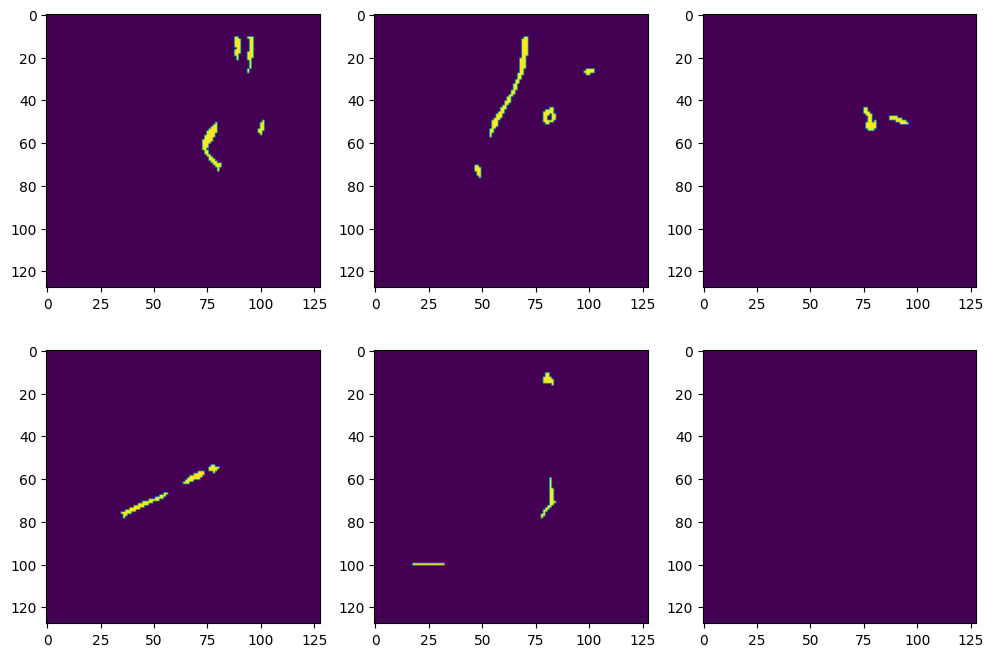

In [3]:
fig = plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(skin[:,:,5*i+11])
    # plt.colorbar()

Subtract background and pad the image to the size of the computaional grid.

In [4]:
gt = skin[:,:,11]
gt -= gt[0,0] # Background subtraction.
pad_x, pad_y = 4*gt.shape[0], 4*gt.shape[1]
gt_pad = np.zeros((gt.shape[0]+2*pad_x, gt.shape[1]+2*pad_y))
gt_pad[pad_x:-pad_x, pad_y:-pad_y] = gt

In [5]:
pathname = gettempdir()

PML_size = 0                               # Size of the PML in grid points.
Nx, Ny = gt_pad.shape
R_ring = 0.05                               # Radius of the ring array [m].
dx, dy = 1.1*2*R_ring/Nx, 1.1*2*R_ring/Ny   # Grid point spacing in the y direction [m].
T_sample = 1/40e6                           # Sample time step [s].

N_transducer = 512                          # Number of transducers in ring array.
center_pos = [0, 0]
arc_angle = 2 * np.pi

kgrid = kWaveGrid([Nx, Ny], [dx, dy])
kgrid.dt = T_sample

Define SOS distribution.

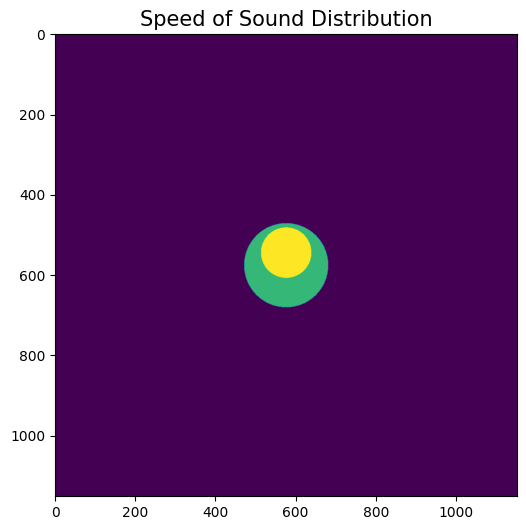

In [6]:
sos_background = 1500.0       # [m/s]
R, R1= 0.01, 0.006          # [m]
offset = 0.003              # [m]

XX, YY = np.meshgrid(kgrid.x_vec.copy(), kgrid.y_vec.copy())
SoS = np.ones((Ny, Nx)) * 1500
SoS[XX**2 + YY**2 < R**2] = 1600
SoS[XX**2 + (YY + offset)**2 < R1**2] = 1650
rou = 1000  # Density.
medium = kWaveMedium(sound_speed=SoS, sound_speed_ref=sos_background, density=rou)

plt.figure(figsize=(6,6))
plt.title('Speed of Sound Distribution', fontsize=15)
plt.imshow(SoS)

### K-wave Forward Simulation

In [7]:
source = kSource()
source.p0 = gt_pad

# Smooth the initial pressure distribution and restore the magnitude.
source.p0 = smooth(source.p0, True)

cart_sensor_mask = makeCartCircle(R_ring, N_transducer, center_pos, arc_angle)
sensor = kSensor(cart_sensor_mask) # Assign to sensor structure.

# Create the time array.
kgrid.makeTime(medium.sound_speed)

# Set the input arguements: force the PML to be outside the computational grid switch off p0 smoothing within kspaceFirstOrder2D.
input_args = {
    'PMLInside': False,
    'PMLSize': PML_size,
    'Smooth': False,
    'SaveToDisk': os.path.join(pathname, f'example_input.h5'),
    'SaveToDiskExit': False, 
}

# Run the simulation.
sensor_data = kspaceFirstOrder2DC(**{
    'medium': medium,
    'kgrid': kgrid,
    'source': source,
    'sensor': sensor,
    # 'reorder_data': True,
    **input_args
})

print(sensor_data.shape)

  start time: 16-Mar-2023-23-22-12
Running k-Wave simulation...
  start time: 16-Mar-2023-23-22-12
  reference sound speed:  1500.0 m/s
  reference sound speed:  1500.0 m/s
  dt:  17.3611ns , t_end: 103.6979us , time steps: 5974
  input grid size: 1152 by 1152 grid points (110.00000000000001 by 110.00000000000001 m)
  maximum supported frequency:  7.8545M Hz
  expanding computational grid...
  computational grid size: 1152 by 1152 grid points
  precomputation completed in  0.04637065902352333 s
  saving input files to disk...
  completed in  16.899781862273812 s
┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                (512, 5974)


In [9]:
def reorder_binary_sensor_data(sensor_data, sensor, kgrid):

    x_sensor = kgrid.x[sensor.mask == 1]
    y_sensor = kgrid.y[sensor.mask == 1]
    
    angle = np.arctan2(-x_sensor, -y_sensor)
    angle[angle < 0] = 2 * np.pi + angle[angle < 0]
    reorder_index = np.argsort(angle)
    
    return sensor_data[reorder_index]

sensor_data = reorder_binary_sensor_data(sensor_data, sensor, kgrid)

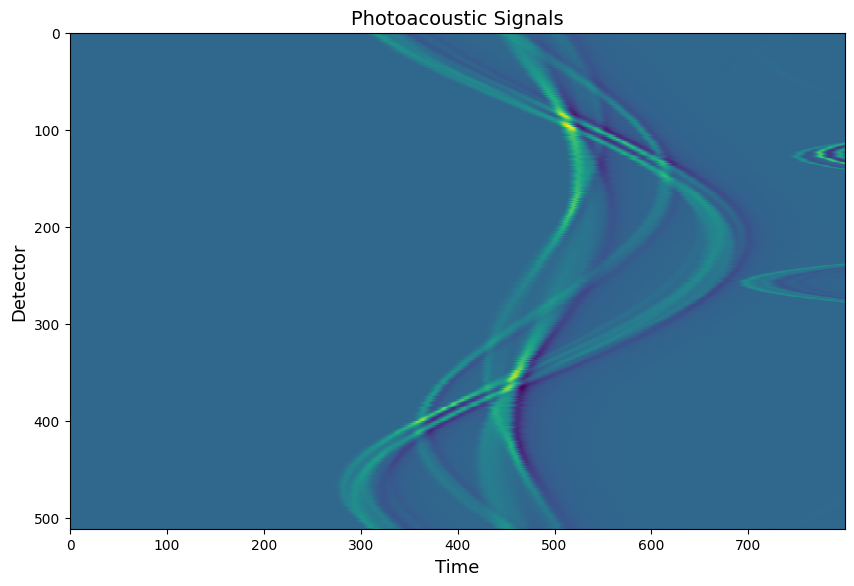

In [10]:
# sensor_data = reorderSensorData(kgrid, sensor, sensor_data)
plt.figure(figsize=(10,10))
plt.title('Photoacoustic Signals', fontsize=14)
plt.xlabel('Time', fontsize=13)
plt.ylabel('Detector', fontsize=13)
plt.imshow(sensor_data[:,1400:2200])
plt.show()

### DAS Reconstruction

In [21]:
@numba.jit(nopython=True) 
def DelayAndSum(R_ring, T_sample, V_sound, Sinogram, x_transducer, y_transducer, ImageX, ImageY, T_delay=0):
    """Generate a 2D Delay And Sum reconstructed PACT image of ring transducer array. This function is accelerated by `numba.jit` on a GPU.

    Args:
        R_ring (`float`): The R_ring [m] of the ring transducer array.
        T_sample (`float`): Sample time interval of the signals [s].
        V_sound (`float`): The sound speed [m/s] used for Delay And Sum reconstruction.
        Sinogram (`numpy.ndarray`): A 2D array and each column of it is the signal recievde by one transducer. The nummber of transducers should be the number of columns. The transducers should be evenly distributed on a circle in counterclockwise arrangement and the first column correspond to the transducer in the dirrection `2pi/N` in the first quartile. The first sample should be at time 0 when the photoacoustic effect happens.
        ImageX (`numpy.ndarray`): The vector [m] defining the x coordinates of the grid points on which the reconstruction is done. The values in the vector should be unifromly-spaced in ascending order. The origin of the cartesian coordinate system is the center of the ring array.
        ImageY (`numpy.ndarray`): The vector [m] defining the y coordinates of the grid points on which the reconstruction is done. The values in the vector should be unifromly-spaced in ascending order. The origin of the cartesian coordinate system is the center of the ring array.
        T_delay (`float`): The delay time [s] of the signals used in DAS. The default value is 0.

    Returns:
        `numpy.ndarray`: A 2D array of size `(len(ImageY), len(ImageX))`. Image(t, s) is the reconstructed photoacoustic amplitude at the grid point (ImageX(s), ImageY(t)).
    """

    N_transducer = Sinogram.shape[0]
    Image = np.zeros((len(ImageX), len(ImageY)))
    delta_angle = 2*np.pi / N_transducer
    angle_transducer = delta_angle * (np.arange(N_transducer,) + 1)

    x_transducer = R_ring * np.sin(angle_transducer - np.pi)
    y_transducer = R_ring * np.cos(angle_transducer - np.pi)
    
    related_data = np.zeros((N_transducer,))
    
    for s in range(len(ImageX)):
        for t in range(len(ImageY)):
            distance_to_transducer = np.sqrt((x_transducer - ImageX[s])**2 + (y_transducer - ImageY[t])**2) - T_delay * V_sound
            for k in range(N_transducer):
                id = floor(distance_to_transducer[k]/(V_sound * T_sample))
                if id > Sinogram.shape[1] or id < 0:
                    related_data[k] = 0
                else:
                    related_data[k] = Sinogram[k, id]
            Image[t, s] = related_data.mean()
    return Image


DelayDistance_step = 0.0000005
N_delays = 9
delays = np.linspace(-(N_delays-1)*DelayDistance_step/2, (N_delays-1)*DelayDistance_step/2, N_delays)
recons = []
for delay in delays:
    recon = DelayAndSum(R_ring, 
                        kgrid.dt, 
                        medium.sound_speed_ref, 
                        sensor_data,
                        None,
                        None,
                        kgrid.x_vec[pad_x:-pad_x], 
                        kgrid.y_vec[pad_y:-pad_y],
                        T_delay=delay)
    recons.append(recon)

Text(0.5, 1.0, 'Ground Truth')

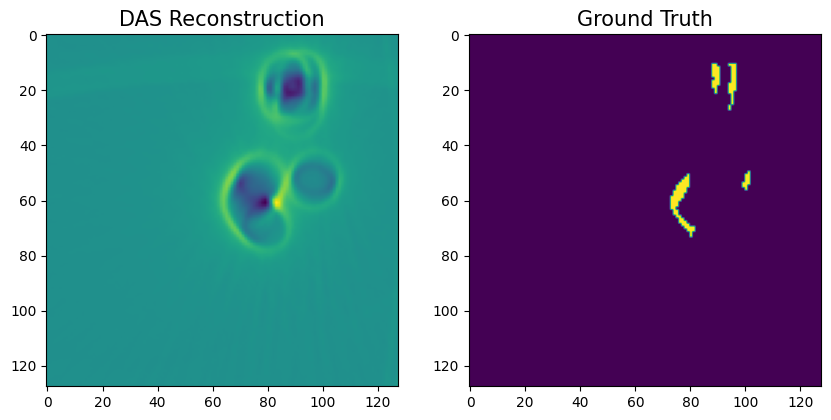

In [22]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(recons[4])
plt.title('DAS Reconstruction', fontsize=15)

plt.subplot(1,2,2)
plt.imshow(gt)
plt.title('Ground Truth', fontsize=15)

Changing delay time.

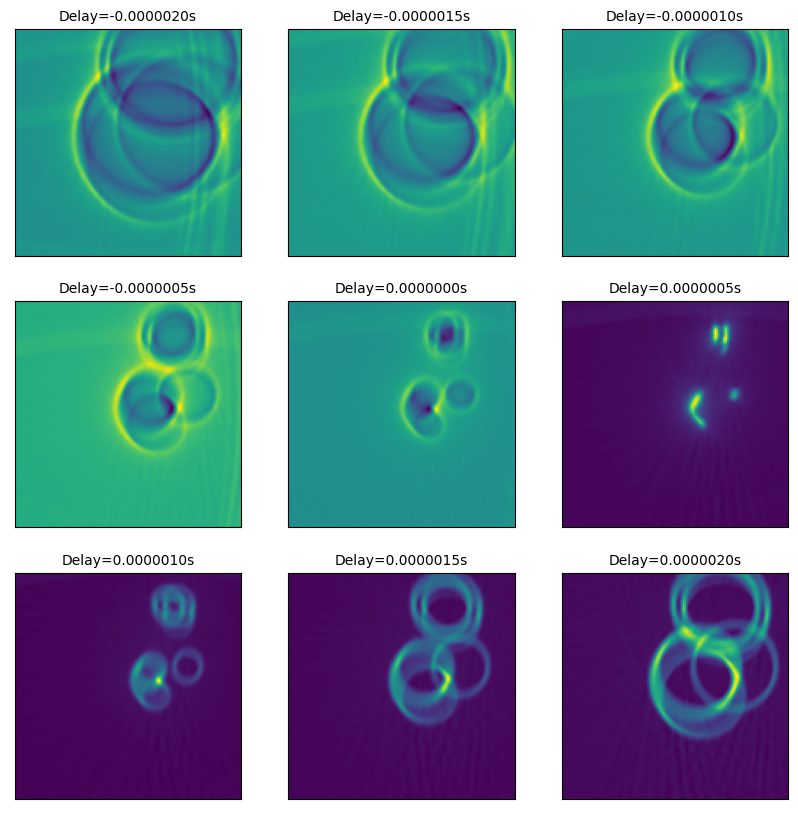

In [23]:
plt.figure(figsize=(10, 10))
for idx, delay in enumerate(delays):
    ax = plt.subplot(3,3,idx+1)
    plt.imshow(recons[idx])
    plt.title('Delay={:.7f}s'.format(delay), fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])